In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split

In [14]:

# Define the CNN Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 7*7*64)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
# Load the Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Assuming train_dataset is already defined and loaded
num_train = int(len(train_dataset) * 0.8)  # 80% for training
num_val = len(train_dataset) - num_train   # 20% for validation

train_data, val_data = random_split(train_dataset, [num_train, num_val])

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Set Up the Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [32]:
def train_with_periodic_validation_and_patience(model, device, train_loader, val_loader, optimizer, criterion, epochs, validation_interval=100, patience=10):
    model.train()
    best_val_loss = float('inf')
    batch_counter = 0
    patience_counter = 0  # Initialize patience counter

    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Increment batch counter
            batch_counter += 1

            # Check validation every 'validation_interval' batches
            if batch_counter % validation_interval == 0:
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for val_data, val_target in val_loader:
                        val_data, val_target = val_data.to(device), val_target.to(device)
                        val_output = model(val_data)
                        val_batch_loss = criterion(val_output, val_target)
                        val_loss += val_batch_loss.item()

                val_loss /= len(val_loader)
                print(f'Batch {batch_counter}, Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

                # Early stopping logic based on validation loss improvement
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0  # Reset patience counter on improvement
                    print("Validation loss decreased, saving model...")
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1
                    print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("Early stopping triggered due to no improvement in validation loss.")
                        return  # Stop training
                model.train()  # Switch back to training mode

train_with_periodic_validation_and_patience(model, device, train_loader, val_loader, optimizer, criterion, epochs=10, validation_interval=500, patience=5)


Batch 500, Epoch 1, Validation Loss: 0.0345
Validation loss decreased, saving model...
Batch 1000, Epoch 1, Validation Loss: 0.0243
Validation loss decreased, saving model...
Batch 1500, Epoch 1, Validation Loss: 0.0247
Validation loss did not improve. Patience: 1/5
Batch 2000, Epoch 2, Validation Loss: 0.0239
Validation loss decreased, saving model...
Batch 2500, Epoch 2, Validation Loss: 0.0281
Validation loss did not improve. Patience: 1/5
Batch 3000, Epoch 2, Validation Loss: 0.0273
Validation loss did not improve. Patience: 2/5
Batch 3500, Epoch 3, Validation Loss: 0.0283
Validation loss did not improve. Patience: 3/5
Batch 4000, Epoch 3, Validation Loss: 0.0304
Validation loss did not improve. Patience: 4/5
Batch 4500, Epoch 3, Validation Loss: 0.0268
Validation loss did not improve. Patience: 5/5
Early stopping triggered due to no improvement in validation loss.


Test Loss: 0.0007136491184335682
Accuracy: 99.36 %


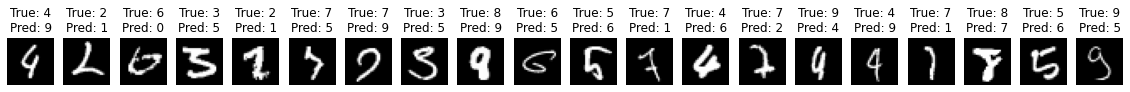

In [34]:
def evaluate_and_show_misclassifications(model, device, test_loader, num_images=5):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Collect misclassified images
            misclassified = pred.eq(target.view_as(pred)) == False
            if len(misclassified_images) < num_images and misclassified.any():
                misclassified_indices = misclassified.nonzero()[:, 0]
                for idx in misclassified_indices:
                    if len(misclassified_images) < num_images:
                        misclassified_images.append(data[idx].cpu())
                        misclassified_labels.append(target[idx].cpu().item())
                        misclassified_predictions.append(pred[idx].cpu().item())
                    else:
                        break

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')
    print(f'Accuracy: {100. * correct / len(test_loader.dataset)} %')

    # Plotting misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i, (img, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_predictions)):
        img = img.squeeze().numpy()  # Squeeze to remove channel dimension and convert to numpy for plotting
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')
    plt.show()

evaluate_and_show_misclassifications(model, device, test_loader, num_images=20
                            )